# Step 10 - Geodesic distances 

In [53]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import pandas as pd

from scipy import sparse
#from scipy.sparse.linalg import splu
#from scipy.sparse.linalg import spilu
#from util import veclen, normalized

from skimage import measure
from scipy.spatial.distance import cdist

from scikits.umfpack import spsolve, splu
from numpy.linalg import norm


In [2]:
# original resolution 120/4,80
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_interfaces") # importing point-positional interface data

C:\Users\Jan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True,
                                  theano_optimizer='fast_compile')

interp_data_grad = gp.InterpolatorData(geo_data, u_grade=[1], output='gradients', compile_theano=True,
                                  theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0
Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [4]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [5]:
def init_domain (geomodel, grid, formation):
        """
        Method to create a new pandas dataframe containing a grid for the SGS. Grid from complete geologic model is
        down to a certain formation of interest.
        Args:
            geomodel (numpy.ndarray): lithological block model created with gempy
            grid (gempy.data_management.GridClass): Grid created for geologic model
            formation (int): Number of formation to perform CoKriging on
        Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, cut to one lith
        """
    
        # convert lith block values to int, thats what Miguel suggested
        lith_block_int = np.round(lith_block)
    
        # create the dataframe and populate with data
        d = {'X': grid.values[:,0], 'Y': grid.values[:,1], 'Z': grid.values[:,2], 'lith': lith_block_int[0], 'grad': lith_block[1]}
        df_cokr = pd.DataFrame(data=d)

        # cut down to wanted lithology and reset dataframne
        df_sgs_grid = df_cokr.loc[df_cokr['lith'] == formation]
        df_sgs_grid = df_sgs_grid.reset_index() # reset indicies
        del df_sgs_grid['index'] # reset indices

        return df_sgs_grid

In [68]:
def veclen(vectors):
    """ return L2 norm (vector length) along the last axis, for example to compute the length of an array of vectors"""
    
    normedA_0 = np.array([norm(v) for v in vectors])
    #normedA_1 = np.array(map(norm, vectors))
    #normedA_2 = map(norm, vectors)
    #normedA_4 = (vectors*vectors).sum(axis=1)**0.5
    
    normedA_5 = np.sqrt(np.sum(vectors**2, axis=-1))
    print(normedA_5.dtype)
    
    return normedA_5
    #return np.sqrt(np.sum(vectors**2, axis=-1))

def normalized(vectors):
    """ normalize array of vectors along the last axis """
    return vectors / veclen(vectors)[..., np.newaxis]


def compute_mesh_laplacian(verts, tris):
    """
    computes a sparse matrix representing the discretized laplace-beltrami operator of the mesh
    given by n vertex positions ("verts") and a m triangles ("tris") 
    
    verts: (n, 3) array (float)
    tris: (m, 3) array (int) - indices into the verts array
    computes the conformal weights ("cotangent weights") for the mesh, ie:
    w_ij = - .5 * (cot \alpha + cot \beta)
    See:
        Olga Sorkine, "Laplacian Mesh Processing"
        and for theoretical comparison of different discretizations, see 
        Max Wardetzky et al., "Discrete Laplace operators: No free lunch"
    returns matrix L that computes the laplacian coordinates, e.g. L * x = delta
    """
    n = len(verts)
    W_ij = np.empty(0)
    I = np.empty(0, np.int32)
    J = np.empty(0, np.int32)
    for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
        vi1 = tris[:,i1] # vertex index of i1
        vi2 = tris[:,i2]
        vi3 = tris[:,i3]
        # vertex vi1 faces the edge between vi2--vi3
        # compute the angle at v1
        # add cotangent angle at v1 to opposite edge v2--v3
        # the cotangent weights are symmetric
        u = verts[vi2] - verts[vi1]
        v = verts[vi3] - verts[vi1]
        
        '''
        # Jan: get zeros out of veclen, create veclen aux
        veclen_aux = veclen(np.cross(u, v))
        for i in range(len(veclen_aux)):
            if veclen_aux[i] == 0:
                veclen_aux[i]=1
        if 0 in veclen_aux:
            print("zero in veclen")
        '''

        #original    
        cotan = (u * v).sum(axis=1) / veclen(np.cross(u, v))
        #Jan:
        #cotan = (u * v).sum(axis=1) / veclen_aux
        
        #if np.isnan(np.sum(cotan)):
            #print("Nan in cotan")
        
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi2)
        J = np.append(J, vi3)
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi3)
        J = np.append(J, vi2)
    L = sparse.csr_matrix((W_ij, (I, J)), shape=(n, n)) 
    
    '''
    # test for fixing the sparse matrix
    c = 100
    a = np.zeros((n, n))
    np.fill_diagonal(a, c)
    
    
    test = L.toarray()
    test = test+a
    L = sparse.csr_matrix(test, shape=(n, n))
    '''
    # control if singular matrices are the real problem - seems so ...
    test = L.toarray()
    
    if np.isnan(np.sum(test)):
        print("Nan values")
    # test if any row is all zeros
    #print(test.any(axis=1))
    np.set_printoptions(threshold=np.nan)
    #print(test)
    #print(test.dtype)
    if np.isfinite(np.linalg.cond(test)):
        B = np.linalg.inv(test)
    else:
        # handle it
        print("Singular Matrix")
    
    
    # compute diagonal entries
    L = L - sparse.spdiags(L * np.ones(n), 0, n, n)
    L = L.tocsr()
    # area matrix
    e1 = verts[tris[:,1]] - verts[tris[:,0]]
    e2 = verts[tris[:,2]] - verts[tris[:,0]]
    n = np.cross(e1, e2)
    triangle_area = .5 * veclen(n)
    # compute per-vertex area
    vertex_area = np.zeros(len(verts))
    ta3 = triangle_area / 3
    for i in range(tris.shape[1]): # Jan: changed xrange to range
        bc = np.bincount(tris[:,i].astype(int), ta3)
        vertex_area[:len(bc)] += bc  
    VA = sparse.spdiags(vertex_area, 0, len(verts), len(verts))
    
    return L, VA


class GeodesicDistanceComputation(object):
    """ 
    Computation of geodesic distances on triangle meshes using the heat method from the impressive paper
        Geodesics in Heat: A New Approach to Computing Distance Based on Heat Flow
        Keenan Crane, Clarisse Weischedel, Max Wardetzky
        ACM Transactions on Graphics (SIGGRAPH 2013)
    Example usage:
        >>> compute_distance = GeodesicDistanceComputation(vertices, triangles)
        >>> distance_of_each_vertex_to_vertex_0 = compute_distance(0)
    """
    def __init__(self, verts, tris, m=10.0):
        self._verts = verts
        self._tris = tris
        # precompute some stuff needed later on
        e01 = verts[tris[:,1]] - verts[tris[:,0]]
        e12 = verts[tris[:,2]] - verts[tris[:,1]]
        e20 = verts[tris[:,0]] - verts[tris[:,2]]
        self._triangle_area = .5 * veclen(np.cross(e01, e12))
        unit_normal = normalized(np.cross(normalized(e01), normalized(e12)))
        self._unit_normal_cross_e01 = np.cross(unit_normal, e01)
        self._unit_normal_cross_e12 = np.cross(unit_normal, e12)
        self._unit_normal_cross_e20 = np.cross(unit_normal, e20)
        # parameters for heat method
        h = np.mean(list(map(veclen, [e01, e12, e20]))) # Jan: converted to list
        
        # Jan: m is constant optimized at 1, here 10 is used
        # Jan: h is mean distance between nodes/length of edges
        t = m * h ** 2
        
        # pre-factorize poisson systems
        Lc, A = compute_mesh_laplacian(verts, tris) 
        self._factored_AtLc = splu((A - t * Lc).tocsc()).solve
        self._factored_L = splu(Lc.tocsc()).solve
        
        '''
        # Jans call, adding c to diagional
        Lc, A = compute_mesh_laplacian(verts, tris) 
        c = 0.00001
        Lc2 = Lc.toarray() + c*np.eye(len(Lc.toarray()))
        A2 = A.toarray() + c*np.eye(len(A.toarray()))
        sLc = sparse.csr_matrix(Lc2)
        sA = sparse.csr_matrix(A2)
        self._factored_AtLc = splu((sA - t * sLc).tocsc()).solve
        self._factored_L = splu(sLc.tocsc()).solve
        '''
    
    def __call__(self, idx):
        """ 
        computes geodesic distances to all vertices in the mesh
        idx can be either an integer (single vertex index) or a list of vertex indices
        or an array of bools of length n (with n the number of vertices in the mesh) 
        """
        u0 = np.zeros(len(self._verts))
        u0[idx] = 1.0
        # heat method, step 1
        u = self._factored_AtLc(u0).ravel()
        # heat method step 2
        grad_u = 1 / (2 * self._triangle_area)[:,np.newaxis] * (
              self._unit_normal_cross_e01 * u[self._tris[:,2]][:,np.newaxis]
            + self._unit_normal_cross_e12 * u[self._tris[:,0]][:,np.newaxis]
            + self._unit_normal_cross_e20 * u[self._tris[:,1]][:,np.newaxis]
        )
        X = - grad_u / veclen(grad_u)[:,np.newaxis]
        # heat method step 3
        div_Xs = np.zeros(len(self._verts))
        for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
            vi1, vi2, vi3 = self._tris[:,i1], self._tris[:,i2], self._tris[:,i3]
            e1 = self._verts[vi2] - self._verts[vi1]
            e2 = self._verts[vi3] - self._verts[vi1]
            e_opp = self._verts[vi3] - self._verts[vi2]
            cot1 = 1 / np.tan(np.arccos( 
                (normalized(-e2) * normalized(-e_opp)).sum(axis=1)))
            cot2 = 1 / np.tan(np.arccos(
                (normalized(-e1) * normalized( e_opp)).sum(axis=1)))
            div_Xs += np.bincount(
                vi1.astype(int), 
        0.5 * (cot1 * (e1 * X).sum(axis=1) + cot2 * (e2 * X).sum(axis=1)), 
        minlength=len(self._verts))
        phi = self._factored_L(div_Xs).ravel()
        phi -= phi.min()
        return phi

In [7]:
# create domain data for certain lithology
domain_data = init_domain(lith_block, geo_data.grid, formation=3)

# set test points
rand_ind1 = np.random.randint(1, len(domain_data))
rand_ind2 = np.random.randint(1, len(domain_data))

pointA = np.array([[domain_data.X[rand_ind1], domain_data.Y[rand_ind1], domain_data.Z[rand_ind1]]])
pointB = np.array([[domain_data.X[rand_ind2], domain_data.Y[rand_ind2], domain_data.Z[rand_ind2]]])

In [8]:
def closest_node(node, nodes):
        closest_ind = cdist(node, nodes).argmin()
        
        dist = cdist(node, nodes)[0][closest_ind] 
    
        return closest_ind, dist

In [9]:
def perpendicular_dist(start_point, grad_val1, grad_val2, interp_data_grad):
    
    step_size = 25 # length of vector
    step = 0
    a = start_point
    
    if grad_val1 < grad_val2:
        #print("loop to bigger")
        for i in range (1000):
            # calculate scalar field vector at point
            grad_vec = gp.compute_model_at(pointA, interp_data_grad)
            grad_vec =np.array([grad_vec[0][2],grad_vec[0][3],grad_vec[0][4]])
            
            # normalize to step size and set direction
            vec_len = np.linalg.norm((grad_vec), ord=1)
            grad_vec_norm = step_size*grad_vec/vec_len
            grad_vec_norm = np.reshape(grad_vec_norm, (1, 3))
            
            a = a+grad_vec_norm
            
            if gp.compute_model_at(a, interp_data)[0][1] > grad_val2:
                break
    
            step += 1
            
    else:
        #print("loop to smaller")
        for i in range (1000):
            # calculate scalar field vector at point
            grad_vec = gp.compute_model_at(pointA, interp_data_grad)
            grad_vec =np.array([grad_vec[0][2],grad_vec[0][3],grad_vec[0][4]])
            
            # normalize to step size and set direction
            vec_len = np.linalg.norm((grad_vec), ord=1)
            grad_vec_norm = step_size*grad_vec/vec_len
            grad_vec_norm = np.reshape(grad_vec_norm, (1, 3))
            grad_vec_norm = grad_vec_norm*(-1)
            
            a = a+grad_vec_norm
            
            if gp.compute_model_at(a, interp_data)[0][1] < grad_val2:
                break
    
            step += 1
    
    dist = step*step_size
    point = a
    
    return dist, point


In [10]:
def parallel_dist(vertices, simplices, point1, point2):
    
    compute_distance = GeodesicDistanceComputation(vertices, simplices)
    
    distance_of_each_vertex_to_vertex_0 = compute_distance(point1)
    
    dist = distance_of_each_vertex_to_vertex_0[point2]
    
    return dist

In [11]:
def check_mesh(verts, tris):
    '''
    Functions that checks if any vertices in a mesh are not referenced by a face
    '''
    for i in range (len(verts)):
        if i not in (tris):
            print("Unreferenced:", i)
    x=1
    return x

In [12]:
def get_distance(pointA, pointB, geo_data, interp_data, interp_data_grad):

    # get resolution of orginal grid and reshape the gradients accordingly
    res = gp.get_resolution(geo_data)
    a = lith_block[1].reshape(res)
    #potential_block = lith_block[1]
    
    # get gradient value at the two locations 
    gradA = gp.compute_model_at(pointA, interp_data)
    gradB = gp.compute_model_at(pointB, interp_data)
    
    # solution for matrix problem ?
    #valueA = np.round(gradA[0][1], 2)
    #valueB = np.round(gradB[0][1], 2)
    
    valueA = gradA[0][1]
    valueB = gradB[0][1]
    #print(pointA)
    #print(pointB)

    # get two mesh planes, one for each point
    # I need to check why step size 2 works but one doesnt
    
    vertices_pA, simplices_pA, normalsA, valuesA = measure.marching_cubes_lewiner(
            a,
            valueA,
            step_size=2,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))
    
    vertices_pB, simplices_pB, normalsB, valuesB = measure.marching_cubes_lewiner(
            a,
            valueB,
            step_size=2,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))
    
    
    '''
    vertices_pA, simplices_pA, normalsA, valuesA = measure.marching_cubes_lewiner(
            potential_block.reshape(interp_data.geo_data_res.resolution[0],
                                    interp_data.geo_data_res.resolution[1],
                                    interp_data.geo_data_res.resolution[2]),
            valueA,
            step_size=2,
            spacing=((interp_data.geo_data_res.extent[1] - interp_data.geo_data_res.extent[0]) / interp_data.geo_data_res.resolution[0],
                     (interp_data.geo_data_res.extent[3] - interp_data.geo_data_res.extent[2]) / interp_data.geo_data_res.resolution[1],
                     (interp_data.geo_data_res.extent[5] - interp_data.geo_data_res.extent[4]) / interp_data.geo_data_res.resolution[2]))

    
    vertices_pA = interp_data.rescaling_factor * vertices_pA + np.array([interp_data._geo_data.extent[0],
                                                                            interp_data._geo_data.extent[2],
                                                                            interp_data._geo_data.extent[4]]).reshape(1, 3)
    
    
    vertices_pB, simplices_pB, normalsB, valuesB = measure.marching_cubes_lewiner(
            potential_block.reshape(interp_data.geo_data_res.resolution[0],
                                    interp_data.geo_data_res.resolution[1],
                                    interp_data.geo_data_res.resolution[2]),
            valueB,
            step_size=2,
            spacing=((interp_data.geo_data_res.extent[1] - interp_data.geo_data_res.extent[0]) / interp_data.geo_data_res.resolution[0],
                     (interp_data.geo_data_res.extent[3] - interp_data.geo_data_res.extent[2]) / interp_data.geo_data_res.resolution[1],
                     (interp_data.geo_data_res.extent[5] - interp_data.geo_data_res.extent[4]) / interp_data.geo_data_res.resolution[2]))

    
    vertices_pB = interp_data.rescaling_factor * vertices_pB + np.array([interp_data._geo_data.extent[0],
                                                                            interp_data._geo_data.extent[2],
                                                                            interp_data._geo_data.extent[4]]).reshape(1, 3)
    
    '''
    
    #x = check_mesh(vertices_pA, simplices_pA)
    #x = check_mesh(vertices_pB, simplices_pB)
    
    # select closest points in mesh
    closeA, distA = closest_node(pointA, vertices_pA)
    closeB, distB = closest_node(pointB, vertices_pB)
    
    #print(distA)
    #print(distB)

    # calculate perpendicular distance towards each triangular mesh respectively
    dist_perpA, pointA2 = perpendicular_dist(pointA, gradA[0][1], gradB[0][1], interp_data_grad)
    dist_perpB, pointB2 = perpendicular_dist(pointB, gradB[0][1], gradA[0][1], interp_data_grad)
    closeA2, distA2 = closest_node(pointA2, vertices_pB)
    closeB2, distA2 = closest_node(pointB2, vertices_pA)
    
    # calculate parallel distance
    dist_paraA = parallel_dist(vertices_pA, simplices_pA, closeA, closeB2)
    dist_paraB = parallel_dist(vertices_pB, simplices_pB, closeB, closeA2)
    
    # calculate full distance
    total_dist = 0.5*(dist_paraA+dist_paraB)+0.5*(dist_perpA+dist_perpB)

    
    check, dist_cdist = closest_node(pointA, pointB)
    
    #print("cdist:", dist_cdist)
    #print("dist_perpA:", dist_perpA)
    #print("dist_perpB:", dist_perpB)
    #print("dist_paraA", dist_paraA)
    #print("dist_paraB", dist_paraB)
    #print("total_dist", total_dist)
    
    return vertices_pA, simplices_pA, vertices_pB, simplices_pB, closeA, closeB, closeA2, closeB2, total_dist

In [13]:
vertices1, simplices1, vertices2, simplices2, closeA, closeB, closeA2, closeB2, dist_result = get_distance(pointA, pointB, geo_data, interp_data, interp_data_grad)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
C:\Users\Jan\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 2.40e+15)
  warnings.warn(msg, UmfpackWarning)
C:\Users\Jan\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.88e+13)
  warnings.warn(msg, UmfpackWarning)


In [14]:
ver , sim = gp.get_surfaces(interp_data, lith_block[1])

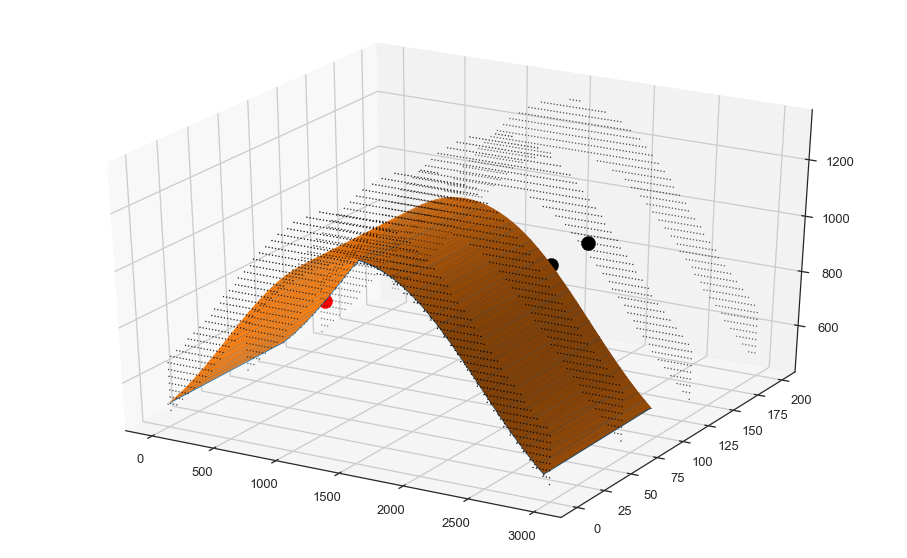

In [15]:
fig = plt.figure(figsize=(16,10))
# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.

ax = fig.add_subplot(1, 1, 1, projection='3d')

#ax.plot_trisurf(ver[1][:,0], ver[1][:,1], ver[1][:,2], triangles=sim[1])
#ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim[2])

ax.scatter3D(xs=pointA[0][0], ys=pointA[0][1], zs=pointA[0][2], s=200, c='black')
ax.scatter3D(xs=pointB[0][0], ys=pointB[0][1], zs=pointB[0][2], s=200, c='red')
ax.scatter3D(xs=domain_data.X, ys=domain_data.Y, zs=domain_data.Z, s=1, c='black')

ax.plot_trisurf(vertices1[:,0], vertices1[:,1], vertices1[:,2], triangles=simplices1)
ax.plot_trisurf(vertices2[:,0], vertices2[:,1], vertices2[:,2], triangles=simplices2)

ax.scatter3D(vertices1[:,0], vertices1[:,1], vertices1[:,2], s=1, c='black')

ax.scatter3D(xs=vertices1[closeA,0], ys=vertices1[closeA,1], zs=vertices1[closeA,2], s=200, c='black')
ax.scatter3D(xs=vertices2[closeB,0], ys=vertices2[closeB,1], zs=vertices2[closeB,2], s=200, c='red')

#ax.scatter3D(xs=vertices1[closeA2,0], ys=vertices1[closeA2,1], zs=vertices1[closeA2,2], s=200, c='black')
#ax.scatter3D(xs=vertices2[closeB2,0], ys=vertices2[closeB2,1], zs=vertices2[closeB2,2], s=200, c='red')

# trying to plot arrows
#soa = np.array([[vertices1[closeA,0], vertices1[closeA,1], vertices1[closeA,2], grad[0][2]*100, grad[0][3]*100, grad[0][4]*100]])

#X, Y, Z, U, V, W = zip(*soa)
#ax.quiver(X, Y, Z, U, V, W)

In [16]:
# following part is just for testing the geodesic distance algorithm

print(sim[1].shape)
print(ver[1].shape)

(1078, 3)
(713, 3)


In [17]:
print(sim[1].shape)
print(simplices1.shape)

(1078, 3)
(184, 3)


In [18]:
compute_distance = GeodesicDistanceComputation(ver[1], sim[1])

In [19]:
point = 20

In [20]:
distance_of_each_vertex_to_vertex_0 = compute_distance(point)

C:\Users\Jan\Anaconda3\lib\site-packages\scikits\umfpack\umfpack.py:721: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.41e+14)
  warnings.warn(msg, UmfpackWarning)


In [21]:
distance_of_each_vertex_to_vertex_0[20]

0.0

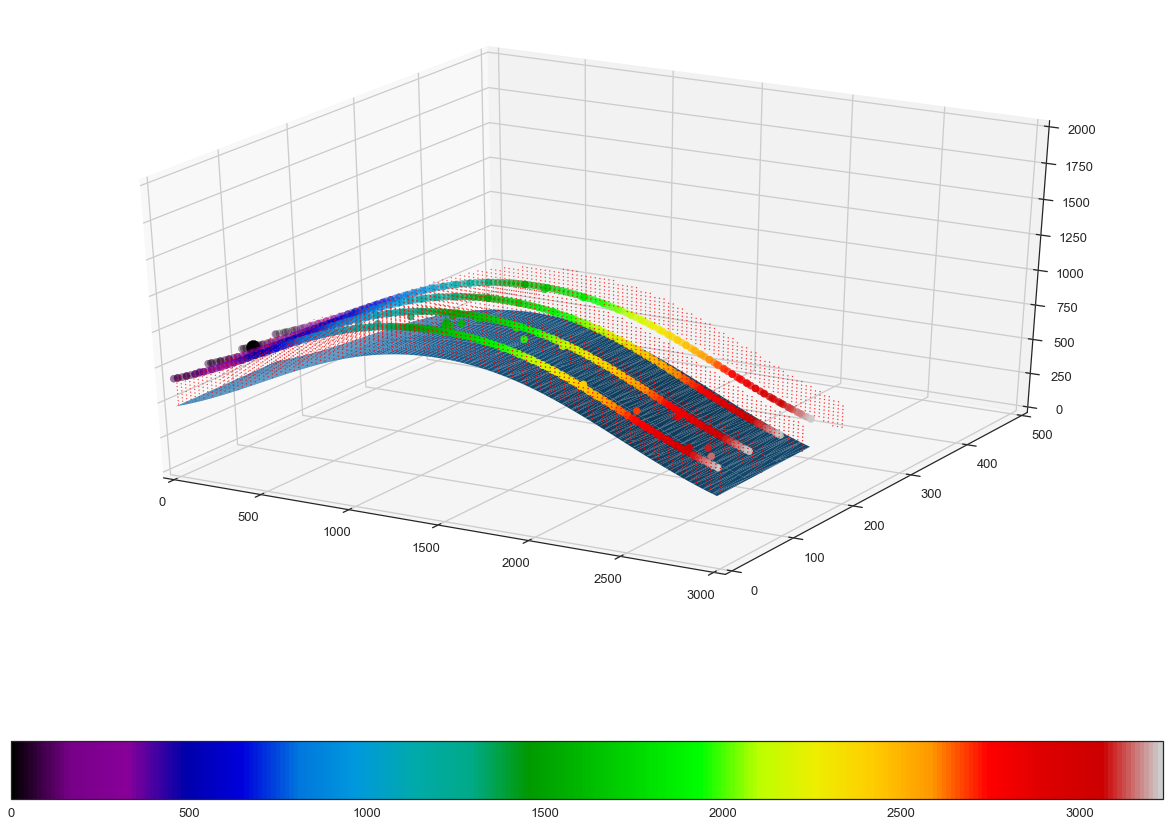

In [22]:
fig = plt.figure(figsize=(16,12))
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,500)
a = ax.scatter3D(xs=ver[1][:,0],ys=ver[1][:,1],zs=ver[1][:,2], c=distance_of_each_vertex_to_vertex_0, cmap='nipy_spectral', s=50)
# a = ax.scatter3D(xs=ver[2][:,0],ys=ver[2][:,1],zs=ver[2][:,2], c='black', cmap='nipy_spectral', s=50)
b = ax.scatter3D(xs=ver[1][point][0],ys=ver[1][point][1],zs=ver[1][point][2], c='black', s=200)
c = ax.scatter3D(xs=domain_data.X,ys=domain_data.Y,zs=domain_data.Z, c='red', s=1)
#d = ax.plot_trisurf(ver[1][:,0], ver[1][:,1], ver[1][:,2], triangles=sim[2])
e = ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim[2])

fig.colorbar(a, orientation='horizontal')

In [23]:
def calculate_distance_set(point, points):
    result = np.zeros((len(points)))
    for i in range (len(points)):
        print("Run:", i)
        result[i] = get_distance(point, points[[i]], geo_data, interp_data, interp_data_grad)[8]
    
    return result

In [24]:
pointA = np.array([[domain_data.X[rand_ind1], domain_data.Y[rand_ind1], domain_data.Z[rand_ind1]]])
pointB = np.array([[domain_data.X[rand_ind2], domain_data.Y[rand_ind2], domain_data.Z[rand_ind2]]])

In [45]:
point = np.array([[domain_data.X[10], domain_data.Y[10], domain_data.Z[10]]])
print(point)

n = 50

dist_points = np.zeros((n, 3))
for i in range (n):
    rand = np.random.randint(0,len(domain_data))
    dist_points[i][0] = domain_data.X[rand]
    dist_points[i][1] = domain_data.Y[rand]
    dist_points[i][2] = domain_data.Z[rand]                          
                      


[[ 12.5      66.94444 535.5485 ]]


In [46]:
dist_points2 = np.array([dist_points[3]])
print(dist_points2)

[[2387.5         199.16667175  987.44726562]]


In [47]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
%%time
test = calculate_distance_set(point, dist_points)
print(test)

Run: 0
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
Run: 1
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
Run: 2
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
flo

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
Run: 21
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
Run: 22
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
Run: 23
float64
float64
float64
float64
float64
float64
float64
float64


float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
Run: 42
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
Run: 43
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [55]:
%%time
compare = cdist(point, dist_points)
print(compare[0])

[2503.48541241 1524.15367404 1015.64203541 2421.22287109  283.40956016
 2676.8843018  2130.79602631 2563.18146597 1831.35160553  897.62114647
  144.05835211 1715.94688236 2215.73029984 2104.76436157  193.69260139
  461.80199992  651.438601    202.18720333 2751.82543942 2728.69067652
  442.773965   1085.08760086 1469.71616903 1146.15418774 2978.3809038
  223.99330084 2508.25611197 2854.83226882 1883.99276649 2072.54397567
  150.42542386 2645.211381    722.04781268 1896.56020667  192.2374678
  206.57443893 2136.71346279  571.19570467 1621.88999008  375.33940089
 2825.88498776 2284.78048153 1942.52509484 1804.83104497  541.31712287
  193.82281362 1140.52578511 2002.44068492  320.42627673 2775.45422307]
Wall time: 4.06 ms


In [30]:
print(test-compare[0])

[   27.11540849   348.14129554   158.36188734    46.9549241
    60.12086382     4.51163698            nan    90.79811764
            nan    55.58795075   289.64135238    18.63514793
    16.8278756    145.44044326   361.0566237    265.32799179
 -1178.45530326   136.36707022   131.38643911   135.08144915
            nan    44.28308919   142.25564004   236.98239234
            nan   -54.64535107   371.5136205             nan
  -159.16520328   118.37164028   309.13694736    20.2778936
    36.04158893            nan            nan    12.13793625
   174.72135939   194.67686589   119.06080262   291.83234539
    79.64514837            nan   124.3684482     76.92033409
   309.17613477   250.63783944   203.07879092   120.84379896
    58.0948907    283.73955544]


In [31]:
#print(dist_points[47][0])
#print(point[0][0])

print(test[2])
print(test[22])
print(test[29])
print(test[44])

print(compare[0][2])
print(compare[0][22])
print(compare[0][29])
print(compare[0][44])

2296.0978628274806
2218.7999099464214
1142.1099376747152
2922.105377371852
2137.7359754833597
2076.5442699053838
1023.7382973913212
2612.929242602166


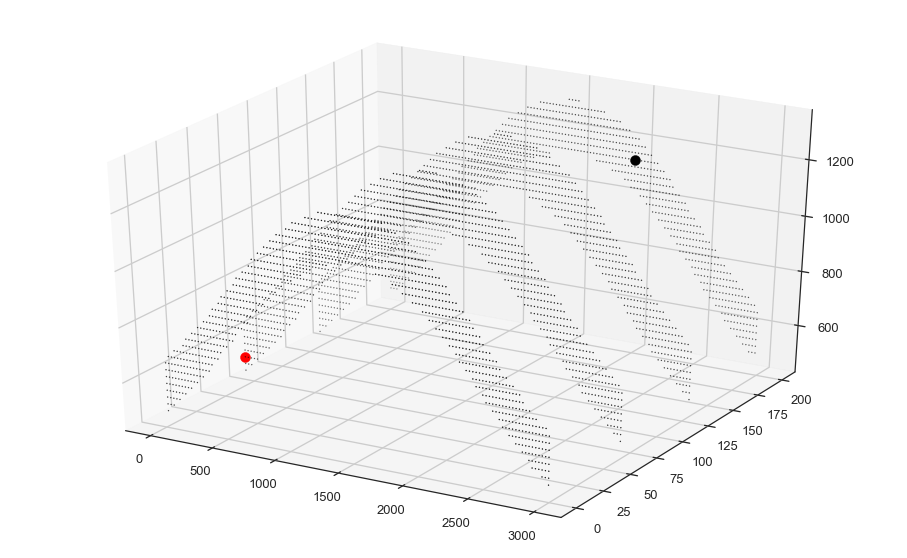

In [32]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter3D(dist_points[22][0], dist_points[22][1], dist_points[2][2], s=100, c='black')
ax.scatter3D(point[0][0], point[0][1], point[0][2], s=100, c='red')

ax.scatter3D(xs=domain_data.X, ys=domain_data.Y, zs=domain_data.Z, s=1, c='black')

In [33]:
# this is the one where it doesnt work
test_pointA = np.array([[1875., 125., 1250.]])

# for this one both options should work
#test_pointA = np.array([[312.5, 0.83333331, 635.97045898]])
print(test_pointA)

gradA = gp.compute_model_at(test_pointA, interp_data)
#gradB = gp.compute_model_at(pointB, interp_data)
    
# solution for matrix problem ?
valuetestA1 = np.round(gradA[0][1], 2)
valuetestA2 = gradA[0][1]

print(valuetestA1)
print(valuetestA2)

restest = gp.get_resolution(geo_data)
atest1 = lith_block[1].reshape(restest)
atest2 = lith_block[1].reshape(restest)

[[1875.  125. 1250.]]
[40.76]
[40.76198]


In [34]:
vertices_testpA1, simplices_testpA1, normalstestA1, valuestestA1 = measure.marching_cubes_lewiner(
            atest1,
            valuetestA1,
            step_size=1,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))

vertices_testpA2, simplices_testpA2, normalstestA2, valuestestA2 = measure.marching_cubes_lewiner(
            atest2,
            valuetestA2,
            step_size=1,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))


In [35]:
# scalar field value rounded
print(vertices_testpA1.shape)
print(simplices_testpA1.shape)

# scalar field value original
print(vertices_testpA2.shape)
print(simplices_testpA2.shape)

#x = (simplices_testpA1==simplices_testpA2).all()
#print(x)


(715, 3)
(1080, 3)
(698, 3)
(1050, 3)


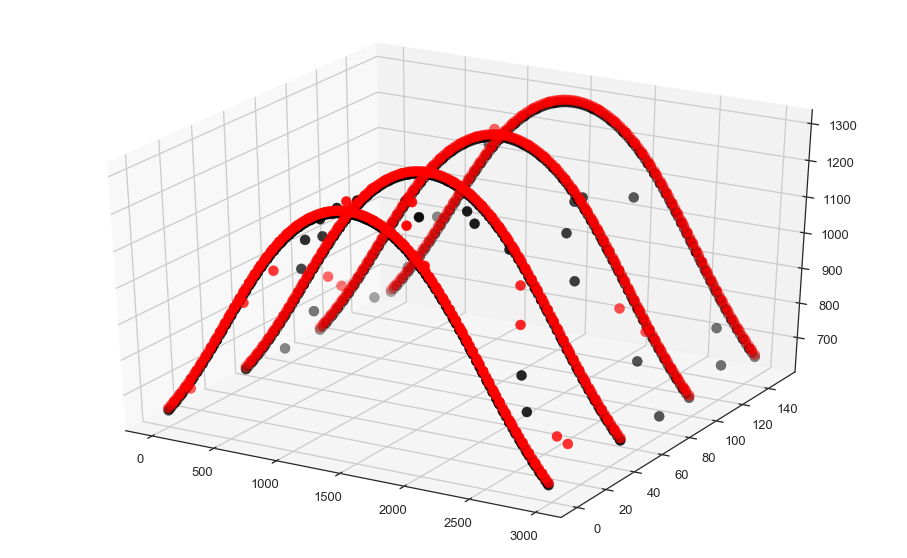

In [36]:
fig = plt.figure(figsize=(16,10))
# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.

ax = fig.add_subplot(1, 1, 1, projection='3d')

#ax.plot_trisurf(ver[1][:,0], ver[1][:,1], ver[1][:,2], triangles=sim[1])
#ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim[2])

# points
#ax.scatter3D(xs=pointA[0][0], ys=pointA[0][1], zs=pointA[0][2], s=200, c='black')
#ax.scatter3D(xs=pointB[0][0], ys=pointB[0][1], zs=pointB[0][2], s=200, c='red')
#ax.scatter3D(xs=domain_data.X, ys=domain_data.Y, zs=domain_data.Z, s=1, c='black')

#ax.plot_trisurf(vertices_testpA1[:,0], vertices_testpA1[:,1], vertices_testpA1[:,2], triangles=simplices_testpA1)#
#ax.plot_trisurf(vertices_testpA2[:,0], vertices_testpA2[:,1], vertices_testpA2[:,2], triangles=simplices_testpA2)

ax.scatter3D(vertices_testpA1[:,0], vertices_testpA1[:,1], vertices_testpA1[:,2], s=100, c='black')
ax.scatter3D(vertices_testpA2[:,0], vertices_testpA2[:,1], vertices_testpA2[:,2], s=100, c='red')

#closest points
#ax.scatter3D(xs=vertices1[closeA,0], ys=vertices1[closeA,1], zs=vertices1[closeA,2], s=200, c='black')
#ax.scatter3D(xs=vertices2[closeB,0], ys=vertices2[closeB,1], zs=vertices2[closeB,2], s=200, c='red')

In [37]:
point=10

In [38]:
compute_distancetestA1 = GeodesicDistanceComputation(vertices_testpA1, simplices_testpA1)

In [39]:
distance_of_each_vertex_to_vertex_0 = compute_distancetestA1(point)
print(distance_of_each_vertex_to_vertex_0)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

In [40]:
compute_distancetestA2 = GeodesicDistanceComputation(vertices_testpA2, simplices_testpA2)

In [41]:
distance_of_each_vertex_to_vertex_0 = compute_distancetestA2(point)
print(distance_of_each_vertex_to_vertex_0)

[5.63411424e+01 2.24143024e+01 4.51933899e+01 1.11228787e+01
 4.27103045e+01 4.14107400e+01 7.87690416e+01 7.74720831e+01
 3.81520166e+01 2.93722123e+00 0.00000000e+00 3.82833199e+01
 4.22011598e+01 4.56901903e+01 7.75836027e+01 8.02761041e+01
 4.91019419e+01 3.31279752e+01 6.60404734e+01 9.20717291e+01
 7.10348865e+01 6.16326509e+01 7.29049203e+01 6.67721294e+01
 8.26718345e+01 9.04731295e+01 9.99228527e+01 1.08232688e+02
 7.23610329e+01 9.92889918e+01 9.87946551e+01 1.16217623e+02
 1.28387026e+02 1.28268398e+02 1.25137248e+02 1.28266569e+02
 1.29996723e+02 1.34383919e+02 1.42591767e+02 1.40287395e+02
 1.50896780e+02 1.28378479e+02 1.57818987e+02 1.60325671e+02
 1.69455067e+02 1.75191240e+02 1.84620873e+02 1.82654269e+02
 1.90142205e+02 1.87547216e+02 1.86070654e+02 1.96748967e+02
 1.87356639e+02 2.00825545e+02 2.17263205e+02 2.19585377e+02
 2.24437668e+02 2.27320598e+02 2.38804079e+02 2.36619608e+02
 2.48843217e+02 2.46801264e+02 2.37194083e+02 2.52422932e+02
 2.36653926e+02 2.546262

 3.24409957e+03 3.23851325e+03]
